# Recommender Systems

# Библиотеки

In [2]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm


# Данные

В качестве данных будем использовать датасет от MTS.AI: [kion-data](https://arxiv.org/pdf/2209.00325.pdf).  
Это информация о просмотрах пользователей различных фильмов и сериалов с названиями, описаниями и прочими фичами. 
**Обратите внимание, что вы можете парсить интернет, для получения дополнительных фичей!**   
Мы заранее поделили выборки на тренировочную и тестовую части, поэтому **просим** вас придерживаться следующих правил: с тренировочными данными разрешается делать **всё что угодно**, тестовую же часть **запрещается изменять**!  

Датасет представляет из себя 4 файла: тренировочную часть (`train_data.csv`), тестовую часть(`test_data.csv`), описание пользователей(`users.csv`) и описание айтемов(`items_.csv`). 

In [3]:
data_folder = "kion_data/"

users_df = pd.read_csv(data_folder + "users.csv")
items_df = pd.read_csv(data_folder + "items.csv")
train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()


# Пользователи

In [4]:
users_df.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,721985,age_45_54,income_20_40,Ж,0
3,704055,age_35_44,income_60_90,Ж,0
4,846063,age_35_44,income_40_60,Ж,1


## Какие есть признаки?

1. `user_id` – индентификатор пользователя, уникален для каждого
2. `age` – категориальный признак, показывающий возрастную группу пользователя
3. `income` – категориальный признак, показывающий зарплатную группу пользователя
4. `sex` – пол пользователя
5. `kids_flg` – наличие детей у пользователя


# Айтемы

In [5]:
items_df.head(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."


## Какие есть признаки?

1. `item_id` – индентификатор айтема, уникален для каждого
2. `content_type` – категориальный признак, тип айтема (фильм, сериал и т.д.)
3. `title` – Название на русском языке
4. `title_orig` – Название на языке оригинала
5. `release_year` – год выхода 
6. `genres` – список жанров (представлен строкой)
7. `countries` – страна издания
8. `for_kids` – предназначен для детей
9. `age_rating` – возрастной рейтинг картины
10. `studios` – студия, выпустившая картину
11. `directors` – режиссер(ы)
12. `actors` – актёры
13. `description` – описание (на русском)
14. `keywords` – ключевые слова, описывающие картину


# Просмотры пользователей

### Тренировачные данные

In [6]:
print(f"Число тренировачных интеракций: {len(train_part):,}")
train_part.head()

Число тренировачных интеракций: 1,224,560


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0


### Тестовые данные

In [7]:
print(f"Число тестовых пользователей: {len(test_part):,}")
test_part.head()

Число тестовых пользователей: 18,693


,user_id,ground_truth
0,30,"[8584, 3031, 15363]"
1,144,"[3800, 11987, 10942]"
2,241,"[14841, 6162, 5808, 15266]"
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]"
4,475,"[6214, 3734, 6686]"


### Обратите внимание, что формат данных тестовой и тренировочной частей отличается. 
#### Это сделано для того, чтобы вы могли использовать дополнительную информацию в своих моделях, например такую как время просмотра (`total_dur`), процент просмотра(`watched_pct`), а так же дату последнего просмотра (`last_watch_dt`)
#### При этом на тренировачных данных такой информации нет, так как мы не можем смотреть в будущее.     

#### Тестовые данные также приведены в удобный для подсчета метрик вид.

# Метрики

#### Кратко расскажем про метрики, которые мы будем использовать для измерения качества наших моделей.  

Всего мы будем смотреть на две метрики: **ndcg** и **recall**.  
Все метрики измеряются до какой-то позиции, у нас это будет **10**. То есть мы отдаем 10 самых подходящих пользователю айтемов по мнению модели и говорим, что это и есть наши рекомендации, качество которых мы хотим оценить.  

**ndcg** показывает, как модель справляется с задачей ранжирования, то есть ставит просмотренные айтемы выше непросмотренных
**recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

*Для обоих метрик лучше та, которая как можно ближе к **1.0***

Не бойтесь, если вам сейчас что-то непонятно, подробнее про метрики мы расскажем на смене или можете почитать в интернете:)

#### Ниже представлен код реализации, пожалуйста, не меняйте его!

In [8]:
# ACHTUNG! DO NOT TOUCH 

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

#### Класс, от которого стоит наследовать все ваши модели, чтобы эксперименты было проще проводить

In [9]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из item_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

### Перейдем к моделям, начнем с супер простого подхода – давайте всем рекомендовать топ популярных (по числу просмотров) айтемов

# Baseline #1 – Топ Популярных

In [10]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
test_part.head()

,user_id,ground_truth,toppopular_recs
0,30,"[8584, 3031, 15363]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
1,144,"[3800, 11987, 10942]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
2,241,"[14841, 6162, 5808, 15266]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
4,475,"[6214, 3734, 6686]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."


##### Посмотрим на метрики, для этого передаем тестовый датафрейм и колонку с предсказаниями, в нашем случае это `toppopular_recs`  

In [11]:
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")


{'ndcg': 0.17037237918248196, 'recall': 0.0763696799665908}

#### Не пугайтесь таких маленьких значений, в RecSys задачах часто очень тяжело подстроиться под данные, поэтому абсолютные значения невелики. Чтобы по-настоящему оценить качество вашей модели, нужно сранвить ее с каким-то простым решением, которое можно считать отправной точкой. Наш бейзлайн с популярными фильмами как раз подходит!

### Теперь возьмем подход посложнее, уже математически подкованный
Мы можем представить просмотры пользователей, как матрицу, где по столбцам будут отложены айтемы, а по строкам – пользователи. В `[i,j]` ячейке будет стоять 1, если пользователь смотрел фильм/сериал и 0, если нет.  
Тогда нашей задачей будет разложить исходную матрицу на две: матрицу пользователей и матрицу айтемов, перемножив которые, мы бы максимально приблизили известные нам единички. 
Такой подход позволит нам заполнить все пропуски в нашей матрице, то есть все нули. 

Для этого метода будем использовать модель **Alternating Least Squares (ALS)**. Она оптимизирует наши матрицы таким образом, чтобы мы хорошо восстанавливали все единички. 
Подробнее про модель можно почитать в [документации](https://benfred.github.io/implicit/), или, например, [тут](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe), или как всегда – в интернете.

![Alt text](./images/mf.png)


# Baseline #2 – Матричное разложение

In [ ]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [13]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


#### Снова считаем метрики 

In [14]:
evaluate_recommender(test_part, model_preds_col="als_recs")


{'ndcg': 0.15702657768326359, 'recall': 0.06956445160783432}

### Ой-ой, кажется, что качество стало хуже, чем у популярных фильмов. Возможно мы плохо обучили модель, не самым правильным образом обработали данные, или она просто не подходит для этих данных, в любом случае, вам предстоит узнать можно ли обогнать `toppop` на данном датасете.

## Сделаем небольшой EDA наших предсказаний от ALS.

### Посмотрим, что наш алгоритм чаще всего рекомендует первым делом:

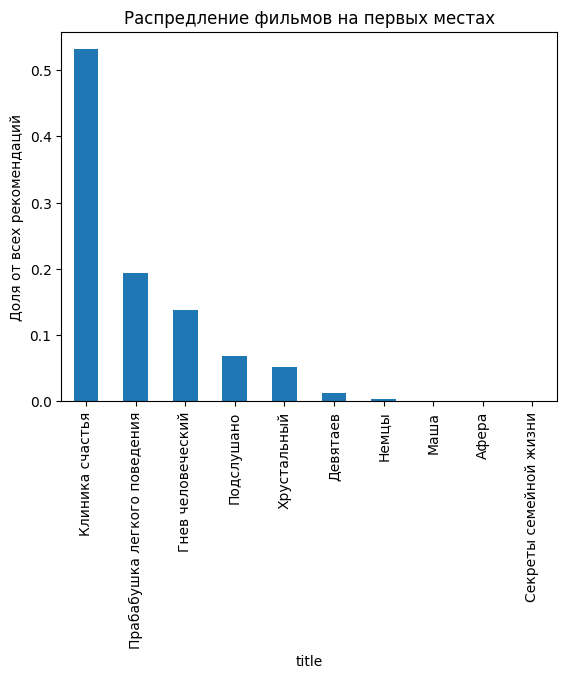

In [15]:
first_items = pd.DataFrame([x[0] for x in test_part["als_recs"].values], columns=["item_id"])
first_items = (
    first_items.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распредление фильмов на первых местах")
plt.show()


#### Посмотрим на похожие фильмы к фильму "Гнев человеческий", согласно als

In [16]:
items_df[items_df["title"] == 'Гнев человеческий']


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
4809,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер..."


In [17]:
def get_similar_films(title, N=10):
    item_id = items_df[items_df["title"] == title]['item_id'].values[0]

    similar_encoded_ids = als_rec.model.similar_items(
        als_rec.item_encoder.transform([item_id]), N=N, filter_items=als_rec.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = als_rec.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["item_id"].isin(similar_ids)]["title"]


In [18]:
get_similar_films("Гнев человеческий")

1120            Мертвые не умирают
3710                 Голос мастера
4070                        Тренер
4509                  Юность Петра
6013             Отстреливая собак
6284     Вселенная Стивена Хокинга
6589            Алиса в Зазеркалье
10036         Убийство на Мидл Бич
10293                  Потрепанные
10338                     Всё могу
Name: title, dtype: object

#### Получается, что "Гнев человеческий" и "Алиса в Зазеркалье" довольно близки.... возможно, возможно

# Так что же нужно сделать?

### tl;dr – красивые визуализации, креативные подходы, различные модели

**Мы не ставим перед вами задачу выбить лучший скор на тестовой выборке** (хотя это очень желательно), задание скорее в том, чтобы исследовать различные подходы, поискать инсайты в данных, построить красивый анализ своих предсказаний и поиграться с данными.

Если говорить более формально, то мы будем оценивать следующее:
1. Какие методы вы попробовали для решения задачи
   ##### Это могут быть
   * статистически подходы, основанные на вашем анализе данных
   * классические метрические методы, вроде knn, а как посчитать вектора пользователей – пусть уже ваша фантазия вам диктует. Здесь вам помогут item-based модели, вроде EASE или SIMPLE
   * затюненный или модифицированный ALS (ну или любая другая модель матричной факторизации)
   * классические модели вроде градиентных бустингов (catboost, lightGBM) тоже работают в таких задачах (вам ведь ничего не мешает учить классификатор на просмотренный и непросмотренный фильмы, правда? осталось только насэмплить вторых)
   * очень приветствуются (но не обязательны) DL подходы, например [DSSM](https://kishorepv.github.io/DSSM/), [NCF](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401), [Bert4Rec](https://towardsdatascience.com/build-your-own-movie-recommender-system-using-bert4rec-92e4e34938c5) или [любой другой алгоритм](https://habr.com/ru/companies/prequel/articles/573880/), который вы найдете, например графовые или дифузионные подходы, почему нет)
     
   В общем нет никаких ограничений на модели, используйте то, что вам нравится или кажется логичным. Не стоит бросаться в крайности: обучать целый зоопарк моделей или затюнить одну до 0 ошибки. Найдите баланс между количеством и качеством)
2. Как хорошо вы валидировали свои модели
3. EDA (Exploration Data Analysis) данных, с которыми вы работаете
4. EDA полученных рекомендаций, насколько они разнообразные, насколько смещены в сторону популярных айтемов и всякое такое
5. **Обязательно** сохраните свою лучшую модель (файлик обученной модели), чтобы мы могли воспроизвести ваш результат!

# Результатом работы должен являться один или два (EDA + обучение моделей) ноутбук(а).